In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler

In [3]:
# Save the DataFrame as a CSV file
data = pd.read_csv('/content/gdrive/MyDrive/Hacking Cars/full_data.csv')
data.shape

(13724462, 11)

In [4]:
data.head()

,timestamp,can_id,byte1,byte2,byte3,byte4,byte5,byte6,byte7,byte8,flag
0,1.478198e+09,018f,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,d8,00,00,8a,00,00,00,00,R


**Considerations for Including `timestamp` and `can_id` as Features in Data:**

- **can_id**:
  - Some attacks might target specific CAN IDs to achieve their goals (e.g., spoofing or flooding specific message types), making `can_id` a useful feature for classification.
  - If an attack method involves a wide range of CAN IDs, the classifier might need additional features to accurately detect such strategies. This could result in a bias towards specific types of attacks commonly associated with certain CAN IDs.

- **timestamp**:
 - The timestamp might introduce noise if the timing patterns are not significantly different between normal and attack messages, potentially reducing classification accuracy.

> Initially, I will drop both `timestamp` and `can_id` and evaluate the performance of the models. Later, I will try adding them back to see if there is any improvement in accuracy and classification quality.


In [5]:
data = data.drop(['timestamp', 'can_id'], axis=1)
data.head(2)

,byte1,byte2,byte3,byte4,byte5,byte6,byte7,byte8,flag
0,fe,5b,00,00,00,3c,00,00,R
1,19,21,22,30,08,8e,6d,3a,R


In [6]:
data['flag'].value_counts(normalize=True)*100

flag
R        83.011961
RPM       4.771750
gear      4.351733
DoS       4.280831
Fuzzy     3.583725
Name: proportion, dtype: float64

In [7]:
normal = data[data['flag']=='R'].sample(frac=0.04, random_state=42)
attacks = data[data['flag']!='R']

final_data = pd.concat([normal, attacks])
final_data.shape

(2787235, 9)

In [8]:
del data

In [9]:
final_data['flag'].value_counts(normalize=True)*100

flag
RPM      23.496297
gear     21.428118
DoS      21.078990
Fuzzy    17.646413
R        16.350182
Name: proportion, dtype: float64

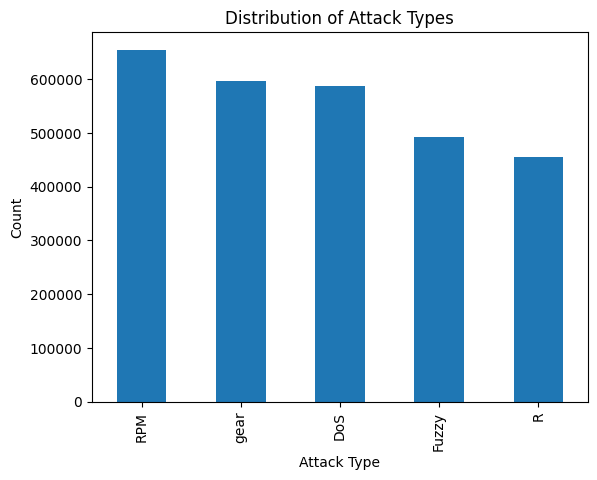

In [10]:
final_data['flag'].value_counts().plot(kind='bar')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title('Distribution of Attack Types')
plt.show();

In [11]:
for col in final_data.columns[:-1]:
  final_data[col] = final_data[col].apply(lambda x: int(x, 16))

In [12]:
final_data.dtypes

byte1     int64
byte2     int64
byte3     int64
byte4     int64
byte5     int64
byte6     int64
byte7     int64
byte8     int64
flag     object
dtype: object

In [13]:
final_data.sample(5)

,byte1,byte2,byte3,byte4,byte5,byte6,byte7,byte8,flag
8054574,1,69,96,255,107,0,0,0,gear
9807844,1,69,96,255,107,0,0,0,gear
1971920,0,0,0,0,0,0,0,0,DoS
8435448,216,0,0,128,0,0,0,0,R
4350160,245,187,60,77,210,168,180,5,Fuzzy


In [18]:
def plot_box_and_hist(column_name):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

  # Boxplot
  sns.boxplot(data=final_data, x=column_name, ax=axes[0])
  axes[0].set_title(f'Boxplot of {column_name}')
  axes[0].set_xlabel(column_name)
  axes[0].set_ylabel('Value')

  # Histogram
  sns.histplot(data=final_data, x=column_name, bins=20, kde=True, ax=axes[1])
  axes[1].set_title(f'Histogram of {column_name}')
  axes[1].set_xlabel(column_name)
  axes[1].set_ylabel('Frequency')

  # Adjust layout
  plt.tight_layout()
  plt.show()

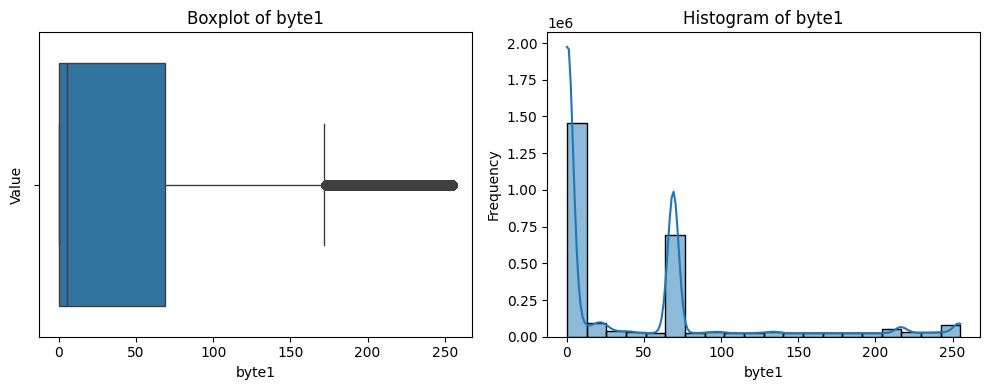

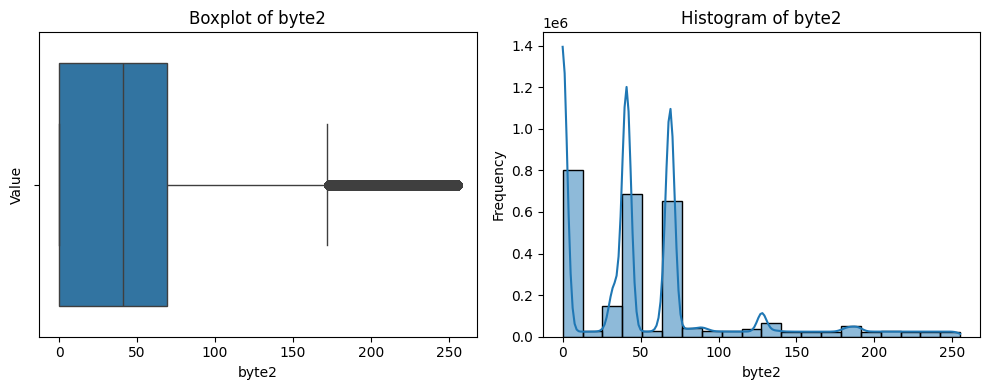

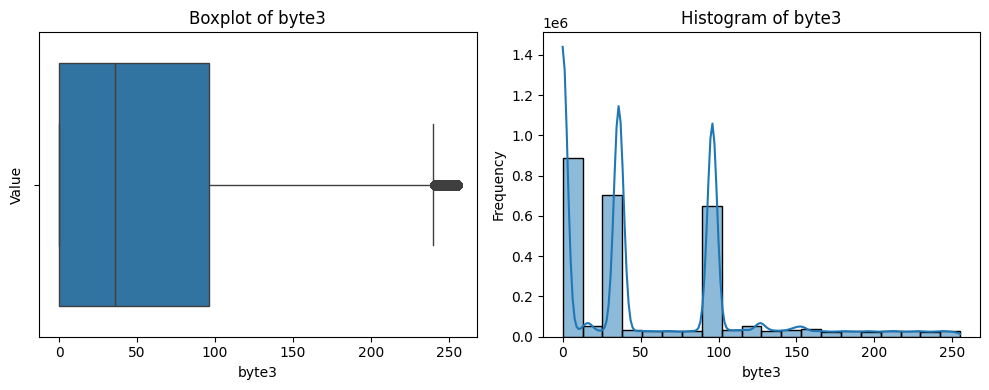

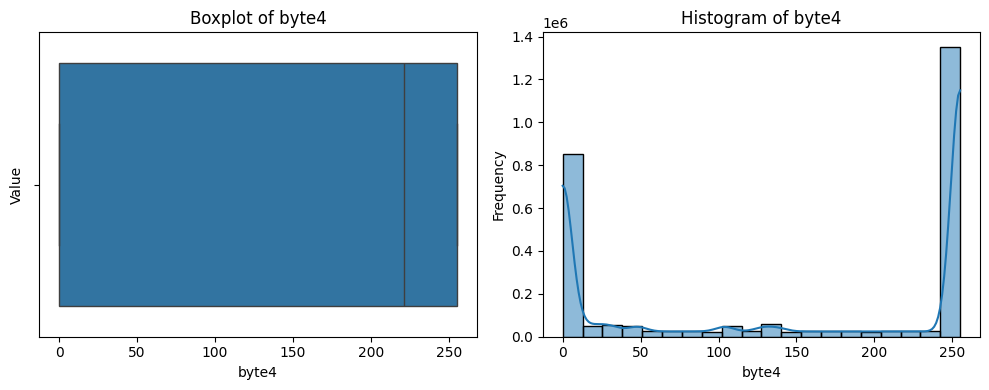

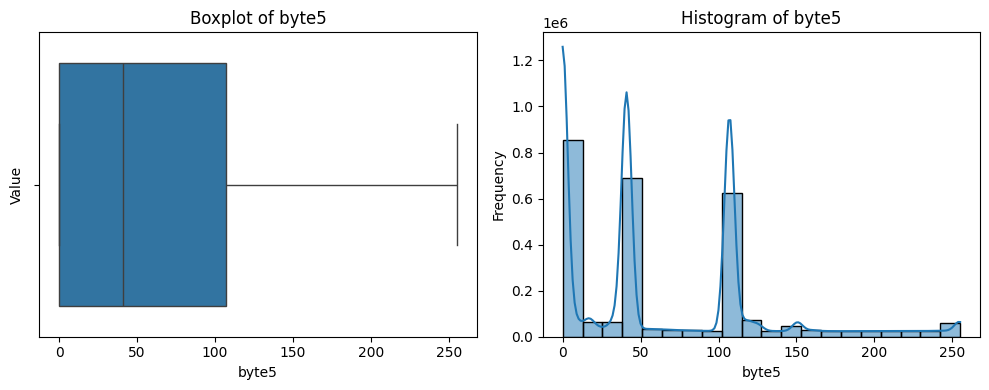

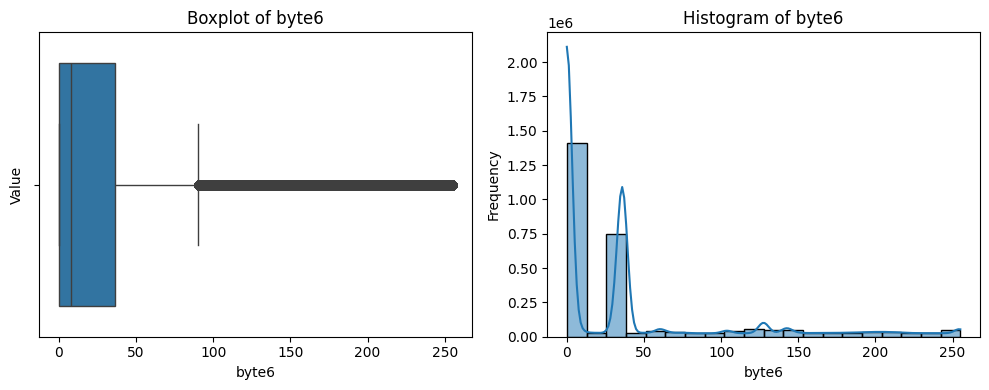

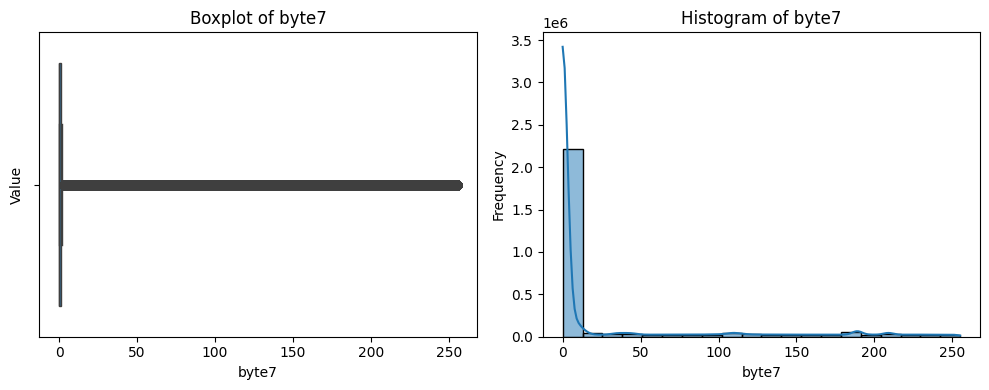

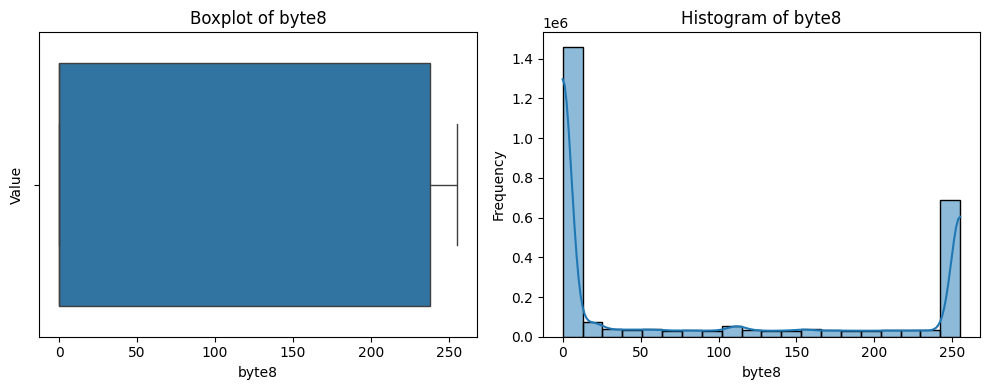

In [19]:
for col in final_data.columns[:-1]:
  plot_box_and_hist(col)

Some columns exhibit outliers:
- `byte1`, `byte2`, and `byte6` have outliers.
- `byte3` has a few outliers.
- `byte7` is filled with outliers.

There are no outliers in `byte4`, `byte5`, and `byte8`.

> As baseline models, I will first use the data as it is. Following that, I will apply different preprocessing techniques such as various types of scaling, dropping some columns, and possibly other transformations.

In [20]:
final_data.to_csv('/content/gdrive/MyDrive/Hacking Cars/final_data.csv', index=False)

In [23]:
train, test = train_test_split(final_data, test_size=0.2, random_state=42)
train.shape, test.shape

((2229788, 9), (557447, 9))

In [24]:
train.to_csv('/content/gdrive/MyDrive/Hacking Cars/train.csv', index=False)
test.to_csv('/content/gdrive/MyDrive/Hacking Cars/test.csv', index=False)

In [25]:
X = train.drop('flag', axis=1)
y = train['flag']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((1783830, 8), (445958, 8))

In [27]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

In [28]:
y_val

array([4, 4, 1, ..., 2, 2, 2])

In [31]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict and evaluate on training data
y_train_pred = model.predict(X_train)
print("Classification Report on Training Data")
print(classification_report(y_train, y_train_pred))

# Predict and evaluate on validation data
y_val_pred = model.predict(X_val)
print("Classification Report on Validation Data")
print(classification_report(y_val, y_val_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report on Training Data
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    375921
           1       0.95      0.94      0.95    314847
           2       0.94      0.91      0.92    291621
           3       1.00      1.00      1.00    419139
           4       1.00      1.00      1.00    382302

    accuracy                           0.97   1783830
   macro avg       0.97      0.97      0.97   1783830
weighted avg       0.97      0.97      0.97   1783830

Classification Report on Validation Data
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     94215
           1       0.95      0.94      0.95     78684
           2       0.94      0.91      0.92     73231
           3       1.00      1.00      1.00    104361
           4       1.00      1.00      1.00     95467

    accuracy                           0.97    445958
   macro avg       0.97      0.97      0.97    4459

In [34]:
robost_scaler = RobustScaler()
X_train_scaled = robost_scaler.fit_transform(X_train)
X_val_scaled = robost_scaler.transform(X_val)
X_val_scaled

array([[-5.79710145e-02,  4.05797101e-01,  6.25000000e-01, ...,
        -2.22222222e-01,  0.00000000e+00,  0.00000000e+00],
       [-5.79710145e-02,  4.05797101e-01,  6.25000000e-01, ...,
        -2.22222222e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.24637681e+00, -5.79710145e-02,  1.91666667e+00, ...,
         2.66666667e+00,  1.13000000e+02,  3.19327731e-01],
       ...,
       [ 3.62318841e+00, -5.94202899e-01, -3.75000000e-01, ...,
         4.91666667e+00,  8.00000000e+00,  0.00000000e+00],
       [ 8.55072464e-01,  2.17391304e+00,  9.47916667e-01, ...,
         6.66666667e-01,  0.00000000e+00,  8.40336134e-02],
       [ 3.60869565e+00,  3.18840580e-01, -3.75000000e-01, ...,
         1.44444444e+00,  0.00000000e+00,  0.00000000e+00]])

### Data Scaling (Robust Scaler)

In [35]:
model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model2.fit(X_train_scaled, y_train)

# Predict and evaluate on training data
y_train_pred = model2.predict(X_train_scaled)
print("Classification Report on Training Data")
print(classification_report(y_train, y_train_pred))

# Predict and evaluate on validation data
y_val_pred = model2.predict(X_val_scaled)
print("Classification Report on Validation Data")
print(classification_report(y_val, y_val_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report on Training Data
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    375921
           1       0.95      0.94      0.95    314847
           2       0.94      0.87      0.90    291621
           3       1.00      1.00      1.00    419139
           4       1.00      1.00      1.00    382302

    accuracy                           0.97   1783830
   macro avg       0.97      0.96      0.96   1783830
weighted avg       0.97      0.97      0.97   1783830

Classification Report on Validation Data
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     94215
           1       0.95      0.95      0.95     78684
           2       0.94      0.87      0.90     73231
           3       1.00      1.00      1.00    104361
           4       1.00      1.00      1.00     95467

    accuracy                           0.97    445958
   macro avg       0.97      0.96      0.96    4459

### Test on Test Data

In [36]:
test.head(2)

,byte1,byte2,byte3,byte4,byte5,byte6,byte7,byte8,flag
4339548,125,17,127,56,243,126,131,19,Fuzzy
12150699,69,41,36,255,41,36,0,255,RPM


In [38]:
flag = encoder.transform(test['flag'])
predictions = model.predict(test.drop('flag', axis=1))
print(classification_report(flag, predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    117385
           1       0.95      0.94      0.95     98316
           2       0.94      0.91      0.92     90866
           3       1.00      1.00      1.00    131397
           4       1.00      1.00      1.00    119483

    accuracy                           0.97    557447
   macro avg       0.97      0.97      0.97    557447
weighted avg       0.97      0.97      0.97    557447

